<a href="https://colab.research.google.com/github/YJJasdasdasd/deeplearning/blob/master/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape,Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# 생성자
generator = Sequential()
generator.add(Dense(128*7*7, input_dim = 100, activation = LeakyReLU(0.2)))
generator.add(BatchNormalization())
generator.add(Reshape((7, 7, 128)))
generator.add(UpSampling2D())
generator.add(Conv2D(64, kernel_size=5, padding='same'))
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D())
generator.add(Conv2D(1, kernel_size=5, padding='same', activation='tanh'))

In [4]:
# 판별자
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, input_shape=(28,28,1), padding='same'))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=5, padding='same'))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.trainable = False

In [5]:
# 생성자와 판별자 모델을 연결시키는 gen 모델을 만듭니다.
ginput = Input(shape=(100,))
dis_output = discriminator(generator(ginput))
gan = Model(ginput, dis_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 28, 28, 1)         865281    
                                                                 
 sequential_1 (Sequential)   (None, 1)                 231681    
                                                                 
Total params: 1,096,962
Trainable params: 852,609
Non-trainable params: 244,353
_________________________________________________________________


In [17]:
# 신경망을 실행시키는ㄴ 함수를 만듭니다.
def gan_train(epoch, batch_size, saving_interval):
# MNIST 데이터 불러오기
    # 앞서 불러온 MNIST를 다시 이용합니다. 테스트 과정은 필요 없고
    # 이미지만 사용할 것이기 때문에 X_train만 호출합니다.
    (X_train, _), (_, _) = mnist.load_data()
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')

    # 127.5를 뺀 후 127.5로 나누어서 -1~1 사이의 값으로 바꿉니다.
    X_train = (X_train - 127.5) / 127.5

    true = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    
    for i in range(epoch):
        # 실제 데이터를 판별자에 입력하는 부분입니다.
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]
        d_loss_real = discriminator.train_on_batch(imgs, true)

        # 가상 이미지를 판별자에 입력하는 부분입니다.
        noise = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(noise)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)

        # 판별자와 생성자의 오차를 계산합니다.
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        g_loss = gan.train_on_batch(noise, true)

        print('epoch:%d' % i, ' d_loss:%.4f' % d_loss, ' g_loss:%.4f' % g_loss)

        # 중간 과정을 이미지로 저장하는 부분입니다. 정해진 인터벌만큼 학습되면
        # 그때 만든 이미지를 gan_images 폴더에 저장하라는 의미입니다.
        # 이 코드는 이 장의 주된 목표와는 관계가 없어서 소스 코드만 소개합니다.
        # if i % saving_interval == 0:

        # r, c = 5, 5
        # noise = np.random.normal(0, 1, (25, 100))
        # gen_imgs = generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(5, 5)
        count = 0
        for j in range(5):
            for k in range(5):
                axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                axs[j, k].axis('off')
                count += 1
        fig.savefig("gan_images/gan_mnist_%d.png" % i)

1/1 [==============================] - 0s 96ms/step
epoch:0  d_loss:0.4902  g_loss:0.3580


FileNotFoundError: ignored

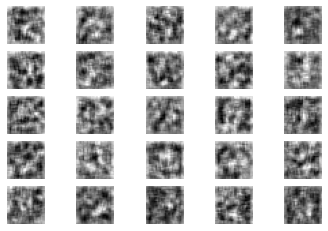

In [19]:
# 2000번 반복되고(+1을 하는 것에 주의),
# 배치 크기는 32, 200번마다 결과가 저장됩니다.
gan_train(1001, 32, 200)